In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
#Read CSV into PANDAS
cars = '../data/vehicle-fuel-type-count-by-zip-code.csv'
geocodes = '../data/fips_zip_correct.csv'
cars_data = pd.read_csv(cars)
geocodes = pd.read_csv(geocodes)

In [3]:
#Get number of unique values for counties
geocodes1 = geocodes[geocodes['State'] == 6]
geocodes1.nunique()

zip       2448
State        1
County      58
dtype: int64

In [4]:
#Get rid of duplicate cars
cars_data.nunique()

Date             1
Zip Code      2915
Model Year      15
Fuel             9
Make           113
Duty             2
Vehicles      2375
dtype: int64

In [5]:
#Define number of cars and and length of car data
print('The number of rows in the car data is ' + str(len(cars_data)))
print('The number of cars in car data is ' + str(cars_data['Vehicles'].sum()))

The number of rows in the car data is 584338
The number of cars in car data is 30411713


In [6]:
#Getting the number of zips per county, by grouping by zip and then counting number of counties
geocodes = geocodes1.rename(columns = {'zip': 'Zip Code', 'County':'COUNTY'})
n_zip_county = geocodes.groupby('Zip Code').count().sort_values(['COUNTY'],ascending = False).reset_index()
n_zip_county.head()

,Zip Code,State,COUNTY
0,93252,4,4
1,95645,3,3
2,95329,3,3
3,95960,3,3
4,95690,3,3


In [7]:
#Creating weights for counties by doing 1/n because there are different
#numbers of counties per zipcode
n_zip_county['Weights'] = 1/n_zip_county['COUNTY']
n_zip_county.head(100)

,Zip Code,State,COUNTY,Weights
0,93252,4,4,0.250000
1,95645,3,3,0.333333
2,95329,3,3,0.333333
3,95960,3,3,0.333333
4,95690,3,3,0.333333
...,...,...,...,...
95,92373,2,2,0.500000
96,95369,2,2,0.500000
97,95367,2,2,0.500000
98,95361,2,2,0.500000


In [8]:
#Renaming zip code for merge
cars_data =cars_data.rename(columns={'Zip Code': 'Zip Code'})
cars_data.head()

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,10/1/2018,90000,2006,Gasoline,OTHER/UNK,Light,1
1,10/1/2018,90000,2014,Gasoline,OTHER/UNK,Light,1
2,10/1/2018,90000,2016,Gasoline,OTHER/UNK,Light,1
3,10/1/2018,90000,2017,Gasoline,OTHER/UNK,Light,1
4,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,Heavy,55


In [9]:
#Reducing zip codes to just zip code and weights
n_zip_county = n_zip_county[['Zip Code','Weights']].sort_values(['Zip Code'])
n_zip_county.head()

,Zip Code,Weights
1250,90001,1.0
2071,90002,1.0
1647,90003,1.0
1648,90004,1.0
1649,90005,1.0


In [10]:
#Mapping n_zips back into geocodes
geocodes_weights = pd.merge(geocodes,n_zip_county,
                            on = 'Zip Code',how = 'inner')
geocodes_weights.head()

,Zip Code,State,COUNTY,Weights
0,90016,6,37,1.0
1,90026,6,37,1.0
2,90018,6,37,1.0
3,96161,6,61,0.5
4,96161,6,57,0.5


In [11]:
#Merging weights/number of car regristrations by zip code into fips code
cars_merge_county = pd.merge(cars_data, geocodes_weights, how="inner", on=["Zip Code"])
cars_merge_county.sort_values(['Weights']).nunique()

Date             1
Zip Code      2376
Model Year      15
Fuel             9
Make           113
Duty             2
Vehicles      2375
State            1
COUNTY          58
Weights          4
dtype: int64

In [12]:
#Multiplying the weights by number of vehicles
cars_merge_county['Adj Veh'] = cars_merge_county['Vehicles']*cars_merge_county['Weights']

cars_merge_county.sort_values(['Weights'], ascending = True).head(2)
cars_merge_county['Zip Code'].nunique()

2376

In [13]:
#Sum the number of cars
sum_cars = cars_merge_county[['Vehicles','Adj Veh','Fuel','COUNTY']].groupby(['Fuel','COUNTY']).sum().rename(columns = {'Vehicles':'Veh','Adj Veh': 'N Adj Veh'}).reset_index()


difference = round(cars_data['Vehicles'].sum() - sum_cars['N Adj Veh'].sum())
percentage = round(difference/cars_data['Vehicles'].sum(),4)

print('The original number of cars is ' + str(cars_data['Vehicles'].sum()))
print('The number of unadjusted vehicles are ' + str(round(sum_cars['Veh'].sum())))
print('The number of adjusted vehicles are ' + str(round(sum_cars['N Adj Veh'].sum())))
print('The difference between the original cars and the adjusted cars is ' + str(difference))
print('The percentage of this change is '+ str(percentage) + ' of the data')

sum_cars.head()

The original number of cars is 30411713
The number of unadjusted vehicles are 33859585
The number of adjusted vehicles are 30386851.0
The difference between the original cars and the adjusted cars is 24862.0
The percentage of this change is 0.0008 of the data


,Fuel,COUNTY,Veh,N Adj Veh
0,Battery Electric,1,20771,17641.333333
1,Battery Electric,3,12,6.000000
2,Battery Electric,5,52,47.000000
3,Battery Electric,7,308,260.000000
4,Battery Electric,9,96,85.833333


In [14]:
#Make county as index, rename, columns, and see total counties
cars_by_county = cars_merge_county[['Vehicles','Adj Veh','COUNTY']].groupby('COUNTY').sum().rename(columns = {'Vehicles':'tot Veh count','Adj Veh':'tot Adj Veh count'})
print('The number of counties after the merge are ' + str(len(cars_by_county)))
cars_by_county.head()

The number of counties after the merge are 58


,tot Veh count,tot Adj Veh count
COUNTY,,
1,1336960,1.162061e+06
3,6571,3.777000e+03
5,43471,3.934100e+04
7,205230,1.606690e+05
9,62906,5.695833e+04


In [16]:
#Merge both tables and find percentages
cars_percentage = pd.merge(sum_cars, cars_by_county,
                           how = 'left', on = 'COUNTY')
cars_percentage['percentage unadjusted'] = cars_percentage['Veh']/cars_percentage['tot Veh count']
cars_percentage['percentage adjusted'] = cars_percentage['N Adj Veh']/cars_percentage['tot Adj Veh count']


cars_percentage = cars_percentage[['Fuel','COUNTY','percentage unadjusted','percentage adjusted']]
cars_percentage.sort_values('COUNTY').set_index('COUNTY').head()

,Fuel,percentage unadjusted,percentage adjusted
COUNTY,,,
1,Battery Electric,0.015536,0.015181
1,Diesel and Diesel Hybrid,0.031110,0.030150
1,Natural Gas,0.000993,0.001050
1,Other,0.000165,0.000175
1,Hydrogen Fuel Cell,0.000258,0.000257


In [17]:
#Manually transposing percentages to type percentage
batt_elect = cars_percentage.loc[cars_percentage['Fuel'] == 'Battery Electric']
batt_elect = batt_elect.rename(columns = {'percentage unadjusted': 'Battery Electric % Unadj', 'percentage adjusted': 'Battery Electric % adj'}).drop(columns = 'Fuel')


hybrid = cars_percentage.loc[cars_percentage['Fuel'] == 'Hybrid Gasoline']
hybrid = hybrid.rename(columns = {'percentage unadjusted': 'Hybrid Gasoline % Unadj', 'percentage adjusted': 'Hybrid Gasoline % adj'}).drop(columns = 'Fuel')

plug = cars_percentage.loc[cars_percentage['Fuel'] == 'Battery Electric']
plug = plug.rename(columns = {'percentage unadjusted': 'Plug Electric % Unadj', 'percentage adjusted': 'Plug Electric % adj'}).drop(columns = 'Fuel')


#Merging back together on county code
bat_hy = pd.merge(batt_elect, hybrid,
                 how = 'right', on ='COUNTY')
final = pd.merge(bat_hy, plug,
                how = 'left', on = 'COUNTY')

final['% Unadj Low Emission'] = final['Battery Electric % Unadj'] + final['Hybrid Gasoline % Unadj'] + final['Plug Electric % Unadj']
final['% Adj Low Emission'] = final['Battery Electric % adj'] + final['Hybrid Gasoline % adj'] + final['Plug Electric % adj']

top_5_evs = final.sort_values('% Adj Low Emission', ascending = False).head(5)
top_5_count = top_5_evs['COUNTY']
top_5_count.tolist()

low_5_evs = final.sort_values('% Adj Low Emission', ascending = True).head(5)
low_5_count = low_5_evs['COUNTY']



print('The top 5 County Codes are ' + str(top_5_count.tolist()))
print('the bottom 5 County Codes are ' + str(low_5_count.tolist()))

final.head()

The top 5 County Codes are [75, 41, 85, 81, 1]
the bottom 5 County Codes are [35, 49, 63, 25, 21]


,COUNTY,Battery Electric % Unadj,Battery Electric % adj,Hybrid Gasoline % Unadj,Hybrid Gasoline % adj,Plug Electric % Unadj,Plug Electric % adj,% Unadj Low Emission,% Adj Low Emission
0,1,0.015536,0.015181,0.051841,0.051366,0.015536,0.015181,0.082913,0.081728
1,3,0.001826,0.001589,0.016284,0.016283,0.001826,0.001589,0.019936,0.019460
2,5,0.001196,0.001195,0.017230,0.017539,0.001196,0.001195,0.019622,0.019928
3,7,0.001501,0.001618,0.022536,0.023527,0.001501,0.001618,0.025537,0.026763
4,9,0.001526,0.001507,0.017629,0.018075,0.001526,0.001507,0.020682,0.021089


In [18]:
#Exporting to CSV
final.to_csv('../data/electric_vehicle_county.csv')

In [19]:
#Importing asthma and county - county codes data
#Importing pollution data
file = os.path.join('../data/asthma_ed_2011_2017.csv')
file2 = os.path.join('../data/geocodes.csv')
file3 = os.path.join('../data/AIR_DATA.csv')
#Renaming columns to match with asthma data
fips = pd.read_csv(file2).rename(columns = {'Area Name (including legal/statistical area description)':'Geography',
                                           'County Code (FIPS)':'COUNTY'})
ed = pd.read_csv(file)


In [20]:
#Removing California State row from asthma data
ed_county = ed.loc[ed['Geography'] != 'California']

#Reducing FIPS data to only California (state code = 6)
fips_cali = fips.loc[fips['State Code (FIPS)'] == 6]

In [21]:
#Adding in county text to asthma data to match FIPS data
ed_county['Geography'] = (ed_county['Geography'] + ' County')

#Merging left join
ed1 = pd.merge(ed_county, fips_cali,
              on = 'Geography', how = 'left')
ed1.head()

C:\Users\14704\AppData\Local\Continuum\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Geography,Year,Age Group,Strata,Strata Name,Numerator,Percent,Summary Level,State Code (FIPS),COUNTY,County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS)
0,Alameda County,2011,18 and Over,Total Population,18 and Over,"6,706",56.6,50.0,6.0,1.0,0.0,0.0,0.0
1,Amador County,2011,18 and Over,Total Population,18 and Over,162,58.1,50.0,6.0,5.0,0.0,0.0,0.0
2,Butte County,2011,18 and Over,Total Population,18 and Over,807,49.9,50.0,6.0,7.0,0.0,0.0,0.0
3,Calaveras County,2011,18 and Over,Total Population,18 and Over,156,49.5,50.0,6.0,9.0,0.0,0.0,0.0
4,Colusa County,2011,18 and Over,Total Population,18 and Over,34,23.4,50.0,6.0,11.0,0.0,0.0,0.0


In [22]:
#Reducing asthma data to all ages and total population
ed2 = ed1.loc[(ed1['Age Group'] == 'All Ages') &
                (ed1['Strata'] == 'Total Population')]
reduced = ed2[['Year','COUNTY','Geography','Percent']]
reduced

,Year,COUNTY,Geography,Percent
361,2011,1.0,Alameda County,61.6
362,2011,5.0,Amador County,66.7
363,2011,7.0,Butte County,53.5
364,2011,9.0,Calaveras County,58.4
365,2011,11.0,Colusa County,30.1
...,...,...,...,...
7200,2017,107.0,Tulare County,43.4
7201,2017,109.0,Tuolumne County,53.6
7202,2017,111.0,Ventura County,34.8
7203,2017,113.0,Yolo County,43.3


In [23]:
#Pulling out top 5 counties for EVs
top_5_ed = reduced[reduced.COUNTY.isin(top_5_count)].drop(columns = 'COUNTY')
top_5_ed.head(5)

,Year,Geography,Percent
361,2011,Alameda County,61.6
380,2011,Marin County,31.2
397,2011,San Francisco County,44.1
400,2011,San Mateo County,39.1
402,2011,Santa Clara County,31.9


In [24]:
#Pulling out lowest 5 counties for EVs
low_5_ed = reduced[reduced.COUNTY.isin(low_5_count)].drop(columns = 'COUNTY')
low_5_ed.head(5)

,Year,Geography,Percent
370,2011,Glenn County,43.3
372,2011,Imperial County,76.4
377,2011,Lassen County,32.7
384,2011,Modoc County,59.1
391,2011,Plumas County,54.2


In [25]:
#Changing data to pivot, for easier graphing 
pivot_high=top_5_ed.pivot(index='Year',columns='Geography')
pivot_low = low_5_ed.pivot(index = 'Year', columns = 'Geography')
pivot_low

Percent                                             \
Geography Glenn County Imperial County Lassen County Modoc County   
Year                                                                
2011              43.3            76.4          32.7         59.1   
2012              37.4            77.9          32.2         60.0   
2013              44.1            67.6          34.3         51.9   
2014              37.7            79.9          34.3         78.0   
2015              42.6            71.2          45.3         67.9   
2016              36.3            66.3          40.7         80.1   
2017              45.6            65.7          44.0        106.0   

                         
Geography Plumas County  
Year                     
2011               54.2  
2012               46.4  
2013               54.7  
2014               42.0  
2015               56.3  
2016               61.4  
2017               63.2

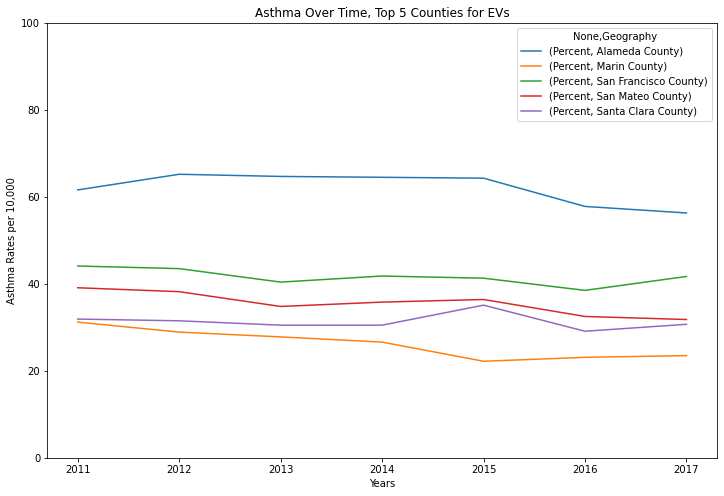

In [27]:
#Graphing each county over time

pivot_high.plot(kind='line', figsize=(12,8))
plt.ylim(0,100)
plt.title('Asthma Over Time, Top 5 Counties for EVs')
plt.xlabel('Years')
plt.ylabel('Asthma Rates per 10,000')

plt.savefig('../output/top_5_asthma.png')

plt.show()